In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from x2 import X2Env, print_grid
from stable_baselines3.common.env_checker import check_env
from eval import eval_model
from checkpoint import load_from_checkpoint
import pandas as pd
import numpy as np

check_env(X2Env())

Loading latest model: models/3eccbcb1-894f-4721-810b-fd5d0279cb73_425.0k.model
67.1821 21.792286240548513


array([[<AxesSubplot:title={'center':'reward'}>]], dtype=object)

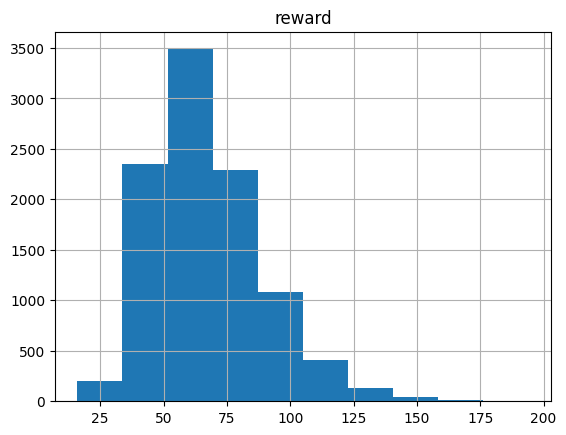

In [3]:
uuid = '3eccbcb1-894f-4721-810b-fd5d0279cb73'
model, _ = load_from_checkpoint(uuid)

rewards = eval_model(model)

print(rewards.mean(), rewards.std())

df = pd.DataFrame(rewards, columns=["reward"])
df.hist()

In [4]:

seed = int(np.argmax(rewards))
print(seed, print(np.max(rewards)))

env = X2Env()
state, _ = env.reset(seed=seed)

iter = 0

194
5005 None


In [220]:
s = env.get_state()

print_grid(s.grid)

action, _ = model.predict(state, deterministic=True)

print(f"iter: {iter}, next: {s.next_play} action: {action}")

next_state, reward, done, _, _ = env.step(action)

print_grid(s.grid)
iter += 1

0009 0007 0006 0009 0007
0010 0009 0003 0008 0006
0008 0007 0002 0006 0003
0003 0006 0001 0007 0006
0006 0002 0004 0002 0003
iter: 215, next: 5 action: 4
0009 0007 0006 0009 0007
0010 0009 0003 0008 0006
0008 0007 0002 0006 0003
0003 0006 0001 0007 0006
0006 0002 0004 0002 0003
